In [1]:
# Imports

In [5]:
import pandas as pd 
import numpy as np 
import missingno
## sklearn
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier # How well does this model improve ? 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

#import category_encoders as ce
from xgboost import XGBClassifier
# VIS 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


SEED=1337

In [6]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

In [7]:
df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [10]:
target = 'damaged'
columns = df.columns.tolist()

In [151]:
## Helper functions
def dataset_basic(train, test, target_col):
    train[target_col].hist()
    plt.show()
    
    print(train.info())
    print(test.info())

def display_features(train):
    feature_types = {}
    for key, value in df.columns.to_series().groupby(df.dtypes).groups.items():
        feature_types[str(key)] = value.tolist()
    return feature_types
        
def nulls_train_test(train,test):
    temp1 = train.isnull().mean().reset_index()
    temp2 = test.isnull().mean().reset_index()
    return temp1.merge(temp2, on='index')

def baseline_train_test(train,test):
    '''
    make sure test & train have same nulls
    '''
    temp1 = train.isnull().mean().reset_index()
    temp2 = test.isnull().mean().reset_index()
    return temp1.merge(temp2, on='index')

def view_unique_values(train):
    columns = train.columns
    for col in columns:
        print(col)
        print(train[col].unique())
        print('------')

In [128]:
feature_types = display_features(df)
feature_types.keys()

dict_keys(['int64', 'float64', 'object'])

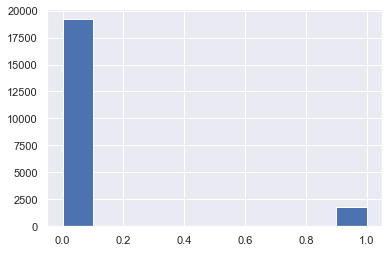

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                21000 non-null  int64  
 1   incident_year     21000 non-null  int64  
 2   incident_month    21000 non-null  int64  
 3   incident_day      21000 non-null  int64  
 4   operator_id       21000 non-null  object 
 5   operator          21000 non-null  object 
 6   aircraft          21000 non-null  object 
 7   aircraft_type     16008 non-null  object 
 8   aircraft_make     15769 non-null  object 
 9   aircraft_model    14741 non-null  float64
 10  aircraft_mass     15306 non-null  float64
 11  engine_make       14845 non-null  float64
 12  engine_model      14666 non-null  object 
 13  engines           15304 non-null  float64
 14  engine_type       15297 non-null  object 
 15  engine1_position  15162 non-null  float64
 16  engine2_position  14224 non-null  float6

In [29]:
dataset_basic(df, test_df, target)

In [131]:
view_unique_values(df)

id
[23637  8075  5623 ...  7800 17294 11145]
------
incident_year
[1996 1999 2011 2007 2013 2002 2015 2004 1993 2009 2000 2014 2010 2003
 2001 1991 1997 1994 2005 2012 1998 1992 1995 2008 1990 2006]
------
incident_month
[11  6 12  9  5  7  8 10  3  1  4  2]
------
incident_day
[ 7 26  1 13 28  4 19 22 21  2 20  6 15  8 17 14 30 18 25  5 11 10 23 29
 16 24 31  3  9 27 12]
------
operator_id
['MIL' 'UAL' 'SWA' 'UNK' 'BUS' 'EGF' 'NWA' 'AAL' 'UPS' 'USA' 'PVT' 'NKS'
 'COM' 'DAL' 'RPA' 'AWI' 'BLR' 'MRA' 'AWE' 'SYM' 'GOV' 'MSS' 'FLG' 'UNKC'
 'JIA' 'PDT' 'FDX' 'FFT' 'ERE' 'QTR' '1AWE' 'TRS' 'FLG*' 'NAE' 'SYX'
 '1AAH' 'MES' 'HAL' 'ASA' '1ASQ' 'AMF' 'BAW' 'USCBP' 'CPA' 'OAE' 'CPZ'
 'SKW' 'WWM' 'ABX' 'SDU' 'JBU' 'BTA' 'ACA' 'VRD' 'PHM' 'JZA' 'GJS' 'ASH'
 'UFS' 'USX' 'JAL' 'COA' 'TCF' 'UCA' 'QXE' 'CMI' 'AAY' 'BSK' 'CHQ' 'ALG'
 'DHL' 'GLA' 'GTI' 'SRV' 'TDX' 'SSV' 'GFT' 'EWW' 'SIA' 'CDL' 'JUS' 'USCG'
 'VAL' 'LOF' 'KAP' 'WAE' 'AMT' 'CEA' 'ENY' 'FLX' 'SNC' 'FRL' 'LSS' 'ASQ'
 'SSX' 'OPT' 'THA' 'FIV' '

In [132]:
## Visualization

In [134]:

feature_types.keys()

dict_keys(['int64', 'float64', 'object'])

In [135]:
feature_types['object']

['operator_id',
 'operator',
 'aircraft',
 'aircraft_type',
 'aircraft_make',
 'engine_model',
 'engine_type',
 'engine3_position',
 'airport_id',
 'airport',
 'state',
 'faa_region',
 'flight_phase',
 'visibility',
 'precipitation',
 'species_id',
 'species_name',
 'species_quantity',
 'flight_impact']

In [150]:
df[feature_types['object']].describe()

operator_id operator aircraft aircraft_type aircraft_make engine_model  \
count        21000    21000    21000         16008         15769        14666   
unique         276      275      424             2            62           39   
top            UNK  UNKNOWN  UNKNOWN             A           148            1   
freq          4838     4838     4927         15755          5780         5252   

       engine_type engine3_position airport_id  airport  state faa_region  \
count        15297             1329      21000    20966  18336      18734   
unique           8                4       1039     1038     60         14   
top              D                1       ZZZZ  UNKNOWN     TX        ASO   
freq         12530              631       2226     2226   1827       3506   

       flight_phase visibility precipitation species_id         species_name  \
count         14272      13301         10673      21000                20993   
unique           12          5             8        447                  445   
top        APPROACH        DAY          NONE      UNKBM  UNKNOWN MEDIUM BIRD   
freq           5756       8376          9704       4725                 4725   

       species_quantity flight_impact  
count             20468         12056  
unique                4             6  
top                   1          NONE  
freq              17675         10657

In [147]:
def visualize_objects(df, obj_columns):
    for col in obj_columns:
        print(col)
        print(df[[col, 'damaged']].groupby([col], as_index=False).mean().sort_values(by='damaged', ascending=False))

        print('Count Of:' + col)
        # Showing  Count of Both gender Male/Female
        print(df.groupby(col).size())

        fig, (axis1,axis2) = plt.subplots(1,2,figsize=(14,6))

        # using .countplot() from seaborn to visualize  Count of each gender and survived percent
        sns.countplot(x = 'damaged', hue=col, data=df, ax =  axis1)
        axis2.set_title('Number of airplanes damaged By ' + col)

        sns.countplot(x='damaged',data=df,hue='damaged', ax = axis2)
        axis1.set_title('Number of airplanes did/didnt get damaged By ' + col)
        plt.show()
        print('-----')

    operator_id  damaged
275         ZAN      1.0
12          ACK      1.0
190         PCM      1.0
201         RAX      1.0
32          ASI      1.0
..          ...      ...
61          CEA      0.0
80          CSK      0.0
128         GWY      0.0
36          AWB      0.0
81          CSN      0.0

[276 rows x 2 columns]
Count Of:operator_id
operator_id
1AAH     62
1ASQ     94
1AWE    138
1EJA      5
1ERH      2
       ... 
WOA       3
WWM       5
XNA       2
XOJ       6
ZAN       1
Length: 276, dtype: int64


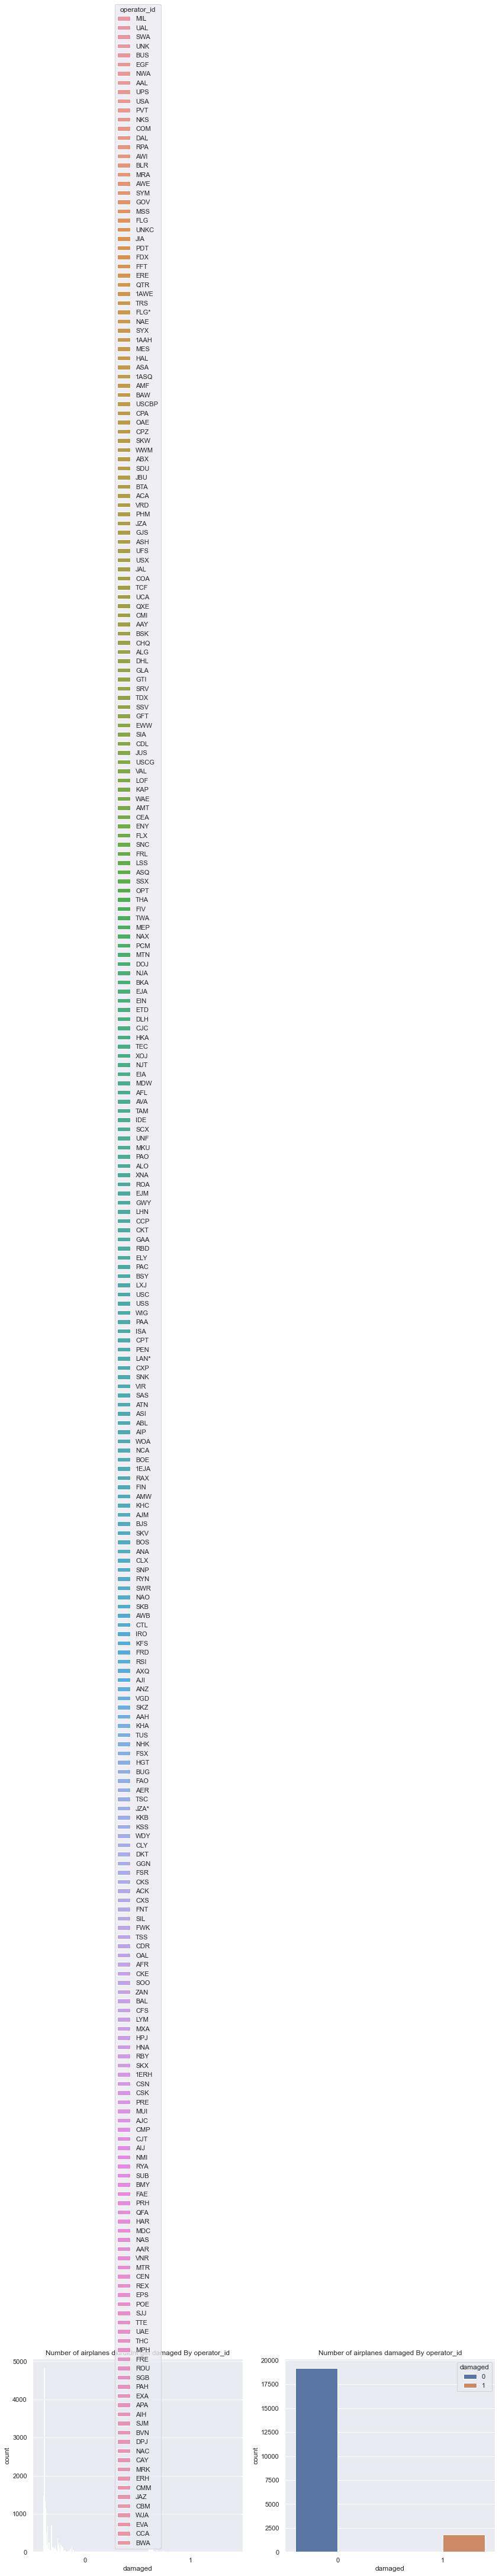

-----
                       operator  damaged
274        ZANTOP INTL AIRLINES      1.0
231             SPIRIT AVIATION      1.0
90                COPA AIRLINES      1.0
55              BIGSKY AIRLINES      1.0
109     EVERGREEN INTL AIRLINES      1.0
..                          ...      ...
167                    MEXICANA      0.0
168              MIAMI AIR INTL      0.0
169        MID-ATLANTIC FREIGHT      0.0
67         CANADA 3000 AIRLINES      0.0
68   CANADIAN REGIONAL AIRLINES      0.0

[275 rows x 2 columns]
Count Of:operator
operator
1US AIRWAYS                    488
ABSA AEROLINHAS BRASILEIRAS      1
ABX AIR                        206
ACTION AIRLINES                  2
ADI SHUTTLE GROUP                8
                              ... 
WINGS WEST                       5
WORLD AIRWAYS                    3
XOJET                            6
XTRA AIRWAYS                     4
ZANTOP INTL AIRLINES             1
Length: 275, dtype: int64


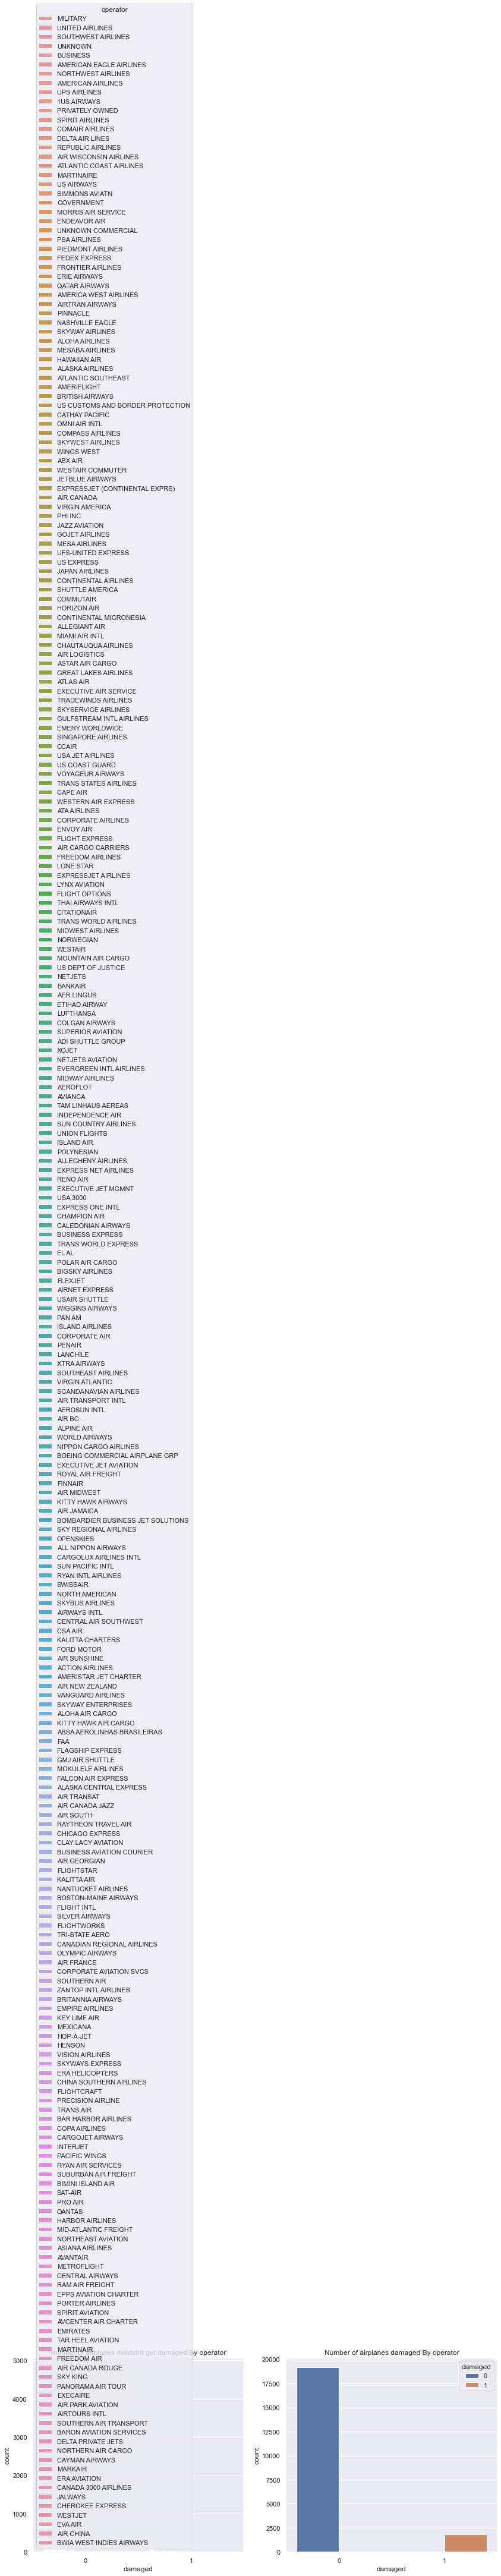

-----
            aircraft  damaged
0               A-10      1.0
390   RKWL SABRLNR40      1.0
386     RKWL CMDR114      1.0
383     REPUBLIC RC3      1.0
74   BE-23 MUSKETEER      1.0
..               ...      ...
312     LEARJET UNKN      0.0
313       LEARJET-23      0.0
174     CHAMPION 7GC      0.0
169       CASA C-212      0.0
423           VC-137      0.0

[424 rows x 2 columns]
Count Of:aircraft
aircraft
A-10                    1
A-10A                  19
A-300                 364
A-310                  95
A-318                  15
                     ... 
U-2S                    1
UNKNOWN              4927
URBAN AIR LAMBADA       1
UV-18B                  1
VC-137                  1
Length: 424, dtype: int64


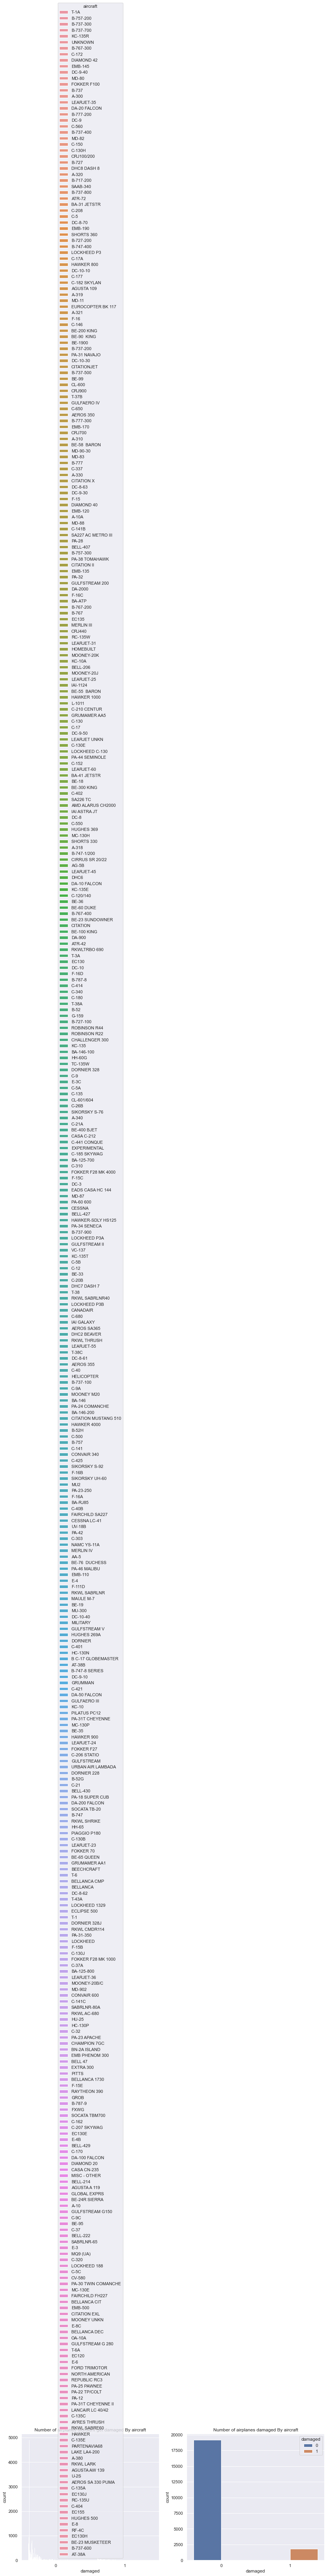

-----
  aircraft_type   damaged
1             B  0.249012
0             A  0.108283
Count Of:aircraft_type
aircraft_type
A    15755
B      253
dtype: int64


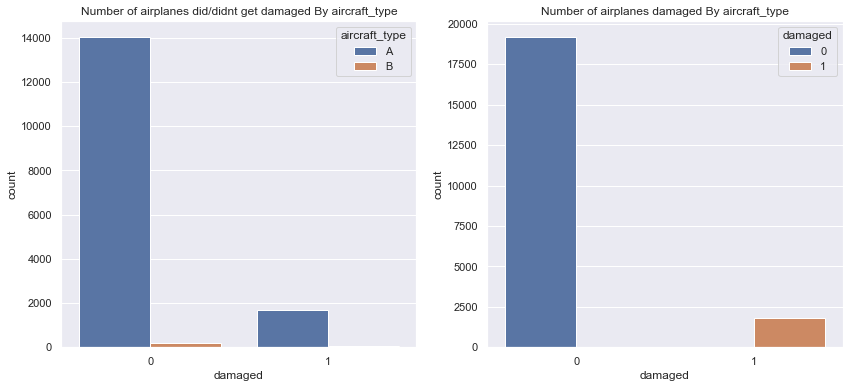

-----
   aircraft_make  damaged
41           659      1.0
33           547      1.0
37           603      1.0
36           584      1.0
51           755      1.0
..           ...      ...
46           721      0.0
10           232      0.0
49           730      0.0
43           672      0.0
13           279      0.0

[62 rows x 2 columns]
Count Of:aircraft_make
aircraft_make
04A    2023
100       1
123     448
128      59
130       7
       ... 
842       2
915      36
97       74
998      27
HEL       4
Length: 62, dtype: int64


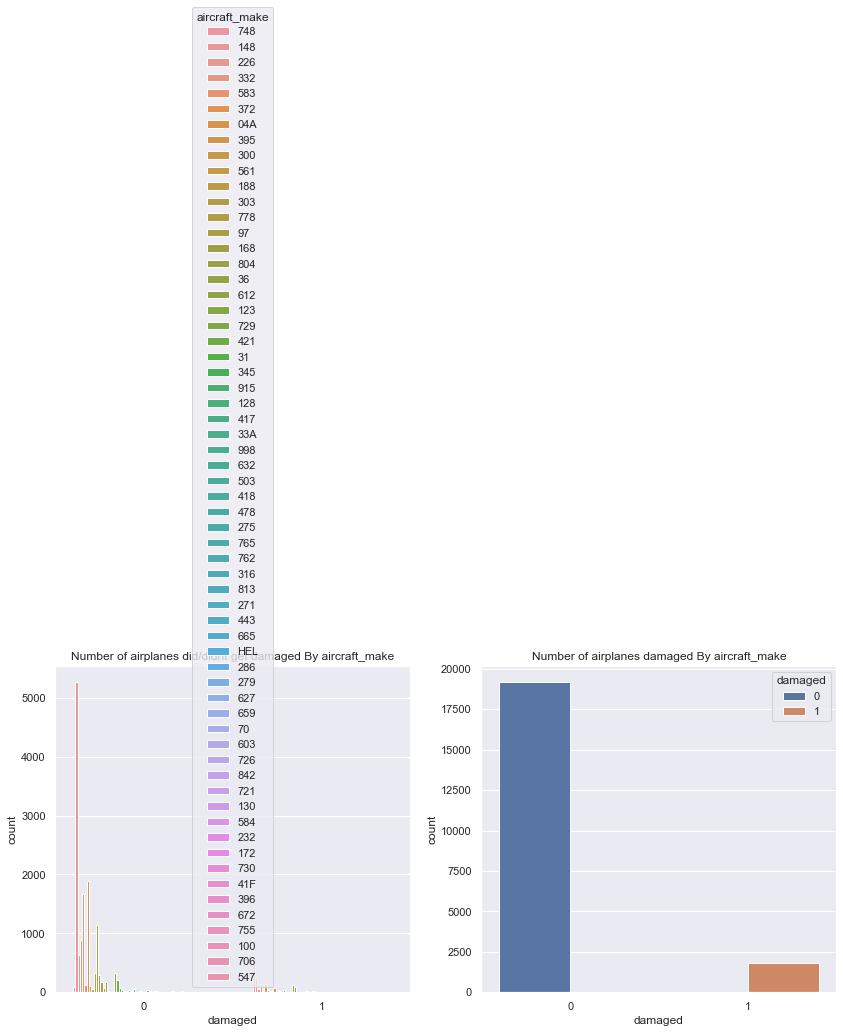

-----
   engine_model   damaged
9            21  1.000000
35           91  1.000000
14           30  0.500000
34            8  0.500000
5            16  0.380208
15           31  0.292994
3            13  0.290503
6            19  0.268722
28           52  0.266667
11           25  0.250000
8            20  0.239583
4            14  0.200000
16           34  0.200000
13            3  0.176471
32           62  0.173913
20            4  0.116033
10           22  0.113122
33            7  0.101883
0             1  0.101866
19           37  0.100977
21           40  0.097065
1            10  0.095197
23           43  0.094340
24           46  0.082037
29           55  0.074074
31            6  0.065089
25           48  0.000000
26           49  0.000000
27           50  0.000000
18           36  0.000000
22           41  0.000000
30           56  0.000000
17           35  0.000000
12           28  0.000000
7             2  0.000000
2            12  0.000000
36           N3  0.000000
37    

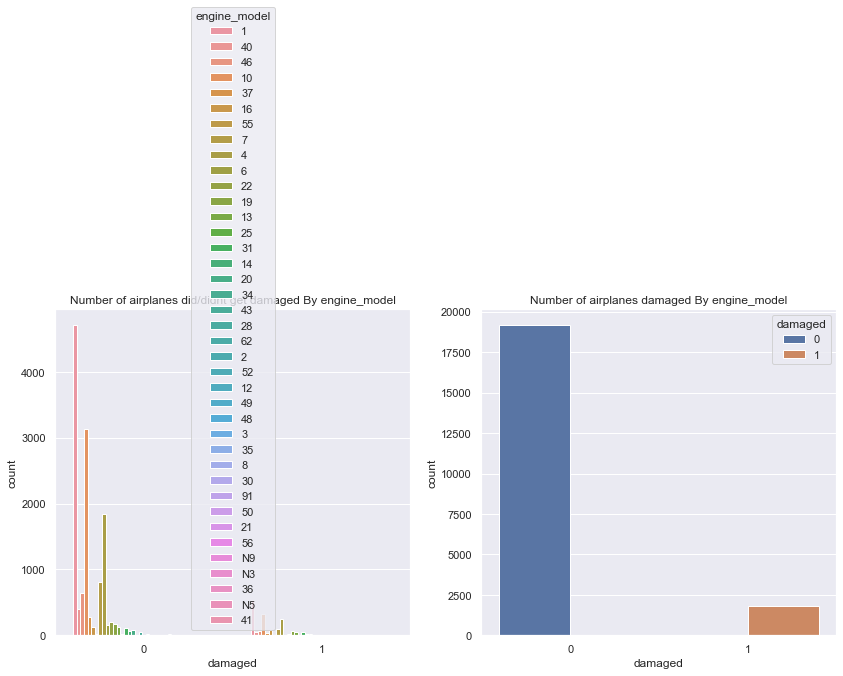

-----
  engine_type   damaged
1         A/C  0.625000
2           B  0.410714
0           A  0.306142
6           F  0.242424
3         B/D  0.200000
4           C  0.145365
5           D  0.087869
7           c  0.000000
Count Of:engine_type
engine_type
A       1042
A/C        8
B         56
B/D        5
C       1424
D      12530
F        231
c          1
dtype: int64


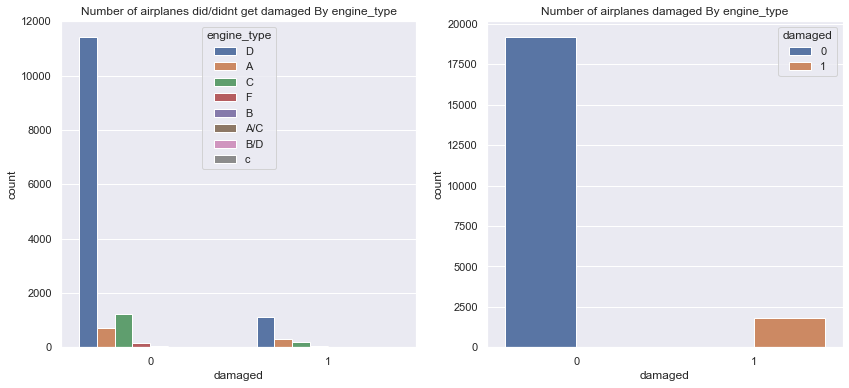

-----
  engine3_position   damaged
3      CHANGE CODE  0.400000
0                1  0.117274
1                4  0.109890
2                5  0.088040
Count Of:engine3_position
engine3_position
1              631
4               91
5              602
CHANGE CODE      5
dtype: int64


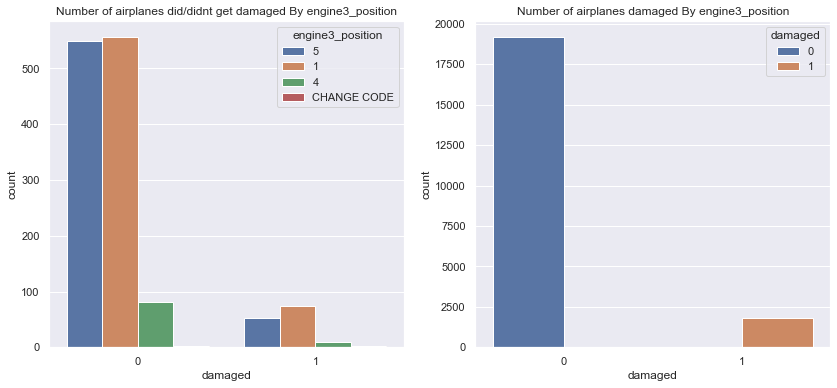

-----
    airport_id  damaged
0          00C      1.0
729       KSEF      1.0
603       KOKM      1.0
138       KART      1.0
601       KOJC      1.0
..         ...      ...
527       KMCB      0.0
353       KFUL      0.0
483       KLBB      0.0
712       KSAF      0.0
769       KSUA      0.0

[1039 rows x 2 columns]
Count Of:airport_id
airport_id
00C        1
02C        1
04W        1
07FA       1
09N        1
        ... 
ZGGG       5
ZGSZ       1
ZSPD       7
ZSQD       1
ZZZZ    2226
Length: 1039, dtype: int64


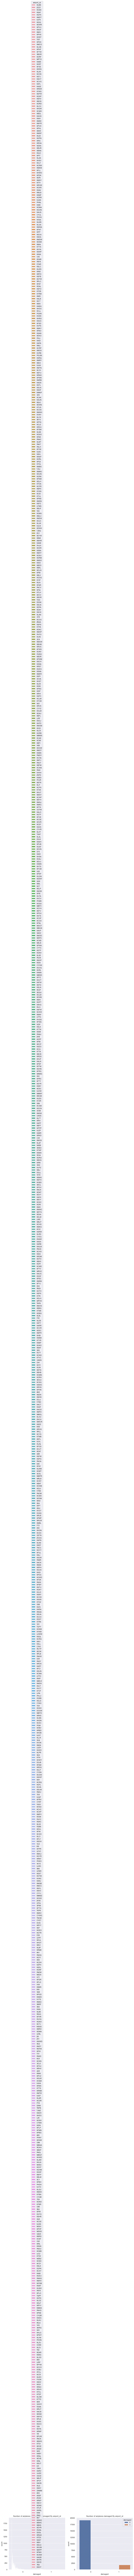

-----
                                airport  damaged
519                    LOGAN-CACHE ARPT      1.0
329                 GILA BEND MUNICIPAL      1.0
351            GREENVILLE DOWNTOWN ARPT      1.0
350   GREENSBURG JEANETTE REGIONAL ARPT      1.0
345                GREAT BENT MUNICIPAL      1.0
...                                 ...      ...
470                        KLAWOCK ARPT      0.0
473           KONA INTL ARPT AT KEAHOLE      0.0
474                   KUALA LUMPUR INTL      0.0
475                  L F WADE INTL ARPT      0.0
1037                             ZURICH      0.0

[1038 rows x 2 columns]
Count Of:airport
airport
ABERDEEN REGIONAL AR            18
ABILENE REGIONAL ARPT           16
ABRAHAM LINCOLN CAPITAL ARPT    18
ABRAMS MUNICIPAL ARPT            1
ACADIANA REGIONAL ARPT           2
                                ..
YOUNGSTOWN-WARREN RGNL ARPT     22
YUMA MCAS/YUMA INTL ARPT         2
ZAMPERINI FIELD ARPT             3
ZEPHYRHILLS MUNICIPAL ARPT       1
ZURICH

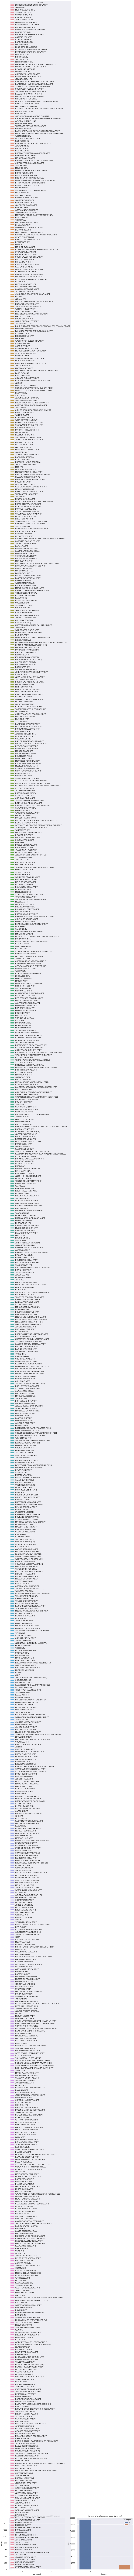

-----
   state   damaged
49    SK  1.000000
48    SD  0.262295
0     AB  0.200000
40    ON  0.190476
59    WY  0.185185
26    MN  0.155462
31    ND  0.136364
10    DE  0.133333
29    MT  0.121951
52    UT  0.115242
56    WA  0.113793
1     AK  0.112150
2     AL  0.110429
53    VA  0.109589
36    NV  0.108434
21    MA  0.105839
14    IA  0.104478
18    KS  0.102564
11    FL  0.102462
58    WV  0.102041
3     AR  0.098214
20    LA  0.097643
12    GA  0.096273
39    OK  0.096070
35    NM  0.094595
6     CA  0.092478
28    MS  0.088496
15    ID  0.084746
27    MO  0.084034
54    VI  0.083333
38    OH  0.080292
25    MI  0.079755
30    NC  0.079365
42    PA  0.078125
24    ME  0.076923
45    QC  0.076923
55    VT  0.076923
43    PI  0.074074
57    WI  0.073913
47    SC  0.073333
34    NJ  0.070707
9     DC  0.069638
16    IL  0.065463
23    MD  0.062500
51    TX  0.061850
17    IN  0.061017
37    NY  0.059946
50    TN  0.058920
8     CT  0.054645
4     AZ  0.053872
41    OR  0.050336
19    

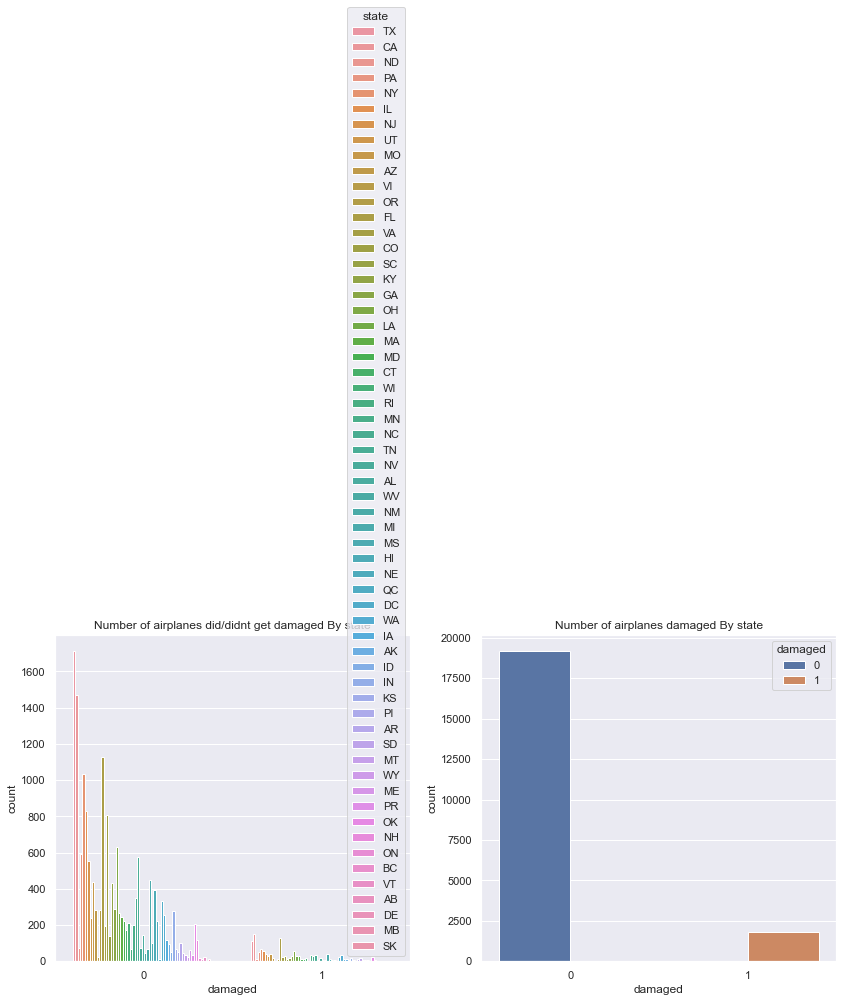

-----
   faa_region   damaged
11        P&N  0.222222
10        ONT  0.190476
0         AAL  0.111111
9         FGN  0.105528
3         AGL  0.084791
6         ASO  0.082145
1         ACE  0.077174
13        QUE  0.076923
8         AWP  0.074980
7         ASW  0.071682
4         ANE  0.071525
2         AEA  0.071184
5         ANM  0.069003
12        PAC  0.000000
Count Of:faa_region
faa_region
AAL     108
ACE     920
AEA    3217
AGL    2972
ANE     741
ANM    1826
ASO    3506
ASW    2539
AWP    2454
FGN     398
ONT      21
P&N       9
PAC      10
QUE      13
dtype: int64


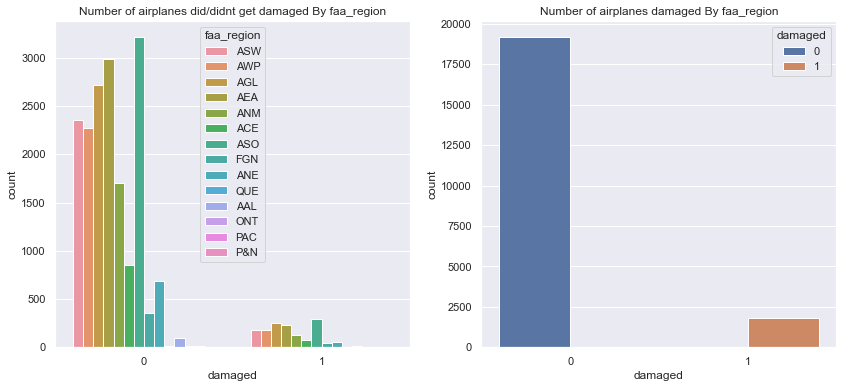

-----
    flight_phase   damaged
5       EN ROUTE  0.386921
4        DESCENT  0.218997
2          CLIMB  0.170576
1        ARRIVAL  0.111111
9         PARKED  0.111111
0       APPROACH  0.092773
10   TAKEOFF RUN  0.091760
11          TAXI  0.080000
7   LANDING ROLL  0.072136
8          LOCAL  0.068966
6        LANDING  0.060976
3      DEPARTURE  0.022727
Count Of:flight_phase
flight_phase
APPROACH        5756
ARRIVAL           18
CLIMB           2345
DEPARTURE         44
DESCENT          379
EN ROUTE         367
LANDING           82
LANDING ROLL    2523
LOCAL             29
PARKED             9
TAKEOFF RUN     2670
TAXI              50
dtype: int64


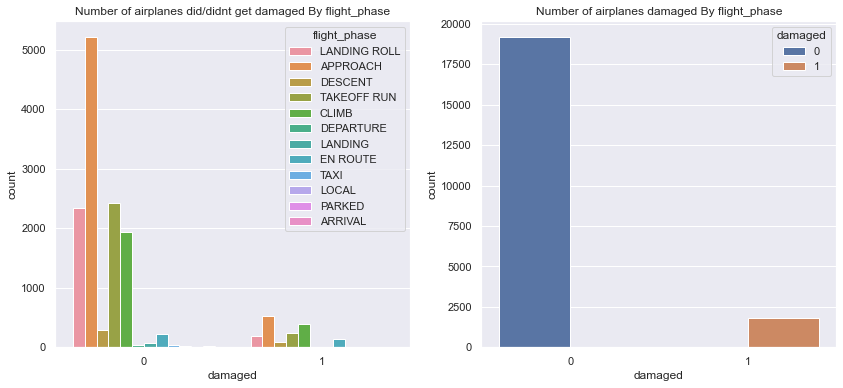

-----
  visibility   damaged
3      NIGHT  0.122108
2       DUSK  0.116776
0       DAWN  0.115566
1        DAY  0.105659
4    UNKNOWN  0.000000
Count Of:visibility
visibility
DAWN        424
DAY        8376
DUSK        608
NIGHT      3890
UNKNOWN       3
dtype: int64


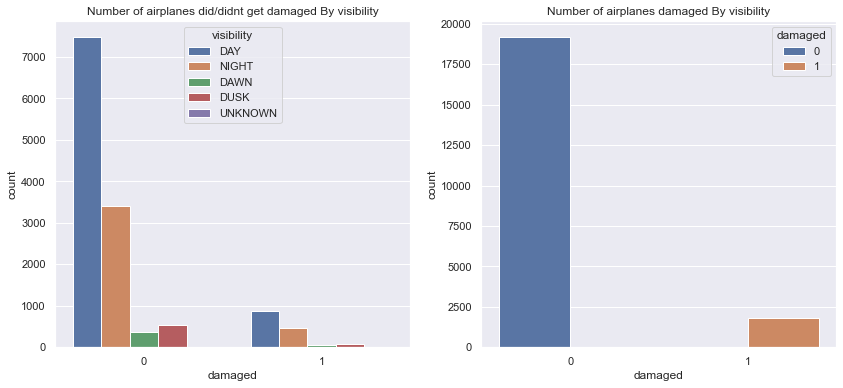

-----
     precipitation   damaged
2  FOG, RAIN, SNOW  0.500000
6       RAIN, SNOW  0.500000
7             SNOW  0.175000
0              FOG  0.168724
5             RAIN  0.128440
1        FOG, RAIN  0.111111
4             NONE  0.109646
3        FOG, SNOW  0.000000
Count Of:precipitation
precipitation
FOG                 243
FOG, RAIN            27
FOG, RAIN, SNOW       2
FOG, SNOW             1
NONE               9704
RAIN                654
RAIN, SNOW            2
SNOW                 40
dtype: int64


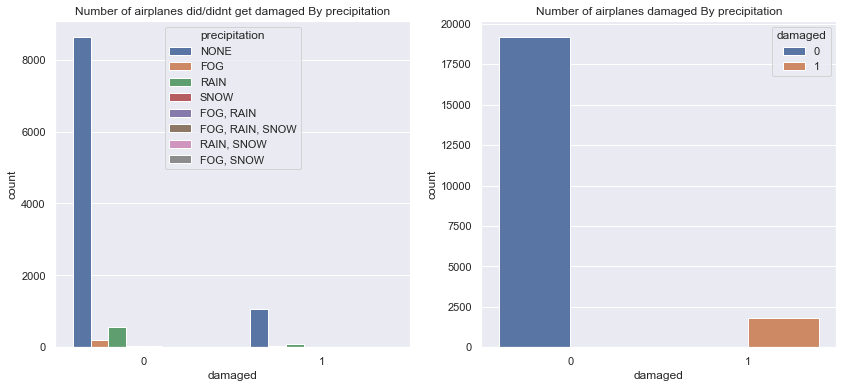

-----
    species_id  damaged
146      K3202      1.0
107      J2111      1.0
45         1G3      1.0
44         1G2      1.0
43        1G12      1.0
..         ...      ...
236      NE217      0.0
235      NE209      0.0
234      NE204      0.0
233      NE203      0.0
0          1A1      0.0

[447 rows x 2 columns]
Count Of:species_id
species_id
1A1      20
1B1       4
1C        3
1C1       2
1C2      88
         ..
ZY1      20
ZY101    11
ZY102     5
ZY103     1
ZZ201    20
Length: 447, dtype: int64


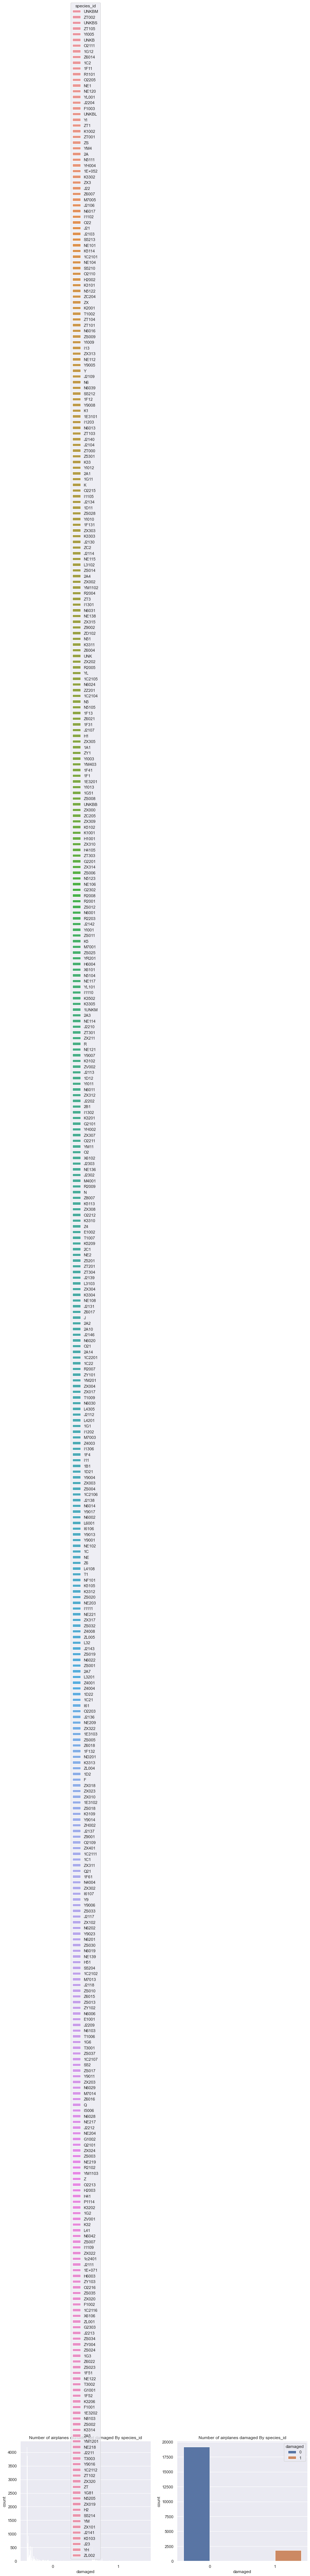

-----
                         species_name  damaged
222          LESSER BLACK-BACKED GULL      1.0
407           WHITE-BELLIED SEA-EAGLE      1.0
350                  SOUTHERN LAPWING      1.0
52   BLACKBIRDS, MEADOWLARKS, ORIOLES      1.0
126                              DEER      1.0
..                                ...      ...
247                  MOURNING WARBLER      0.0
245                 MOUNTAIN BLUEBIRD      0.0
94                 CHUCK-WILL'S-WIDOW      0.0
241                          MEW GULL      0.0
0                  ACADIAN FLYCATCHER      0.0

[445 rows x 2 columns]
Count Of:species_name
species_name
ACADIAN FLYCATCHER          1
ALDER FLYCATCHER            2
AMERICAN ALLIGATOR          4
AMERICAN AVOCET             2
AMERICAN BITTERN            1
                           ..
YELLOW-HEADED BLACKBIRD     1
YELLOW-LEGGED GULL          1
YELLOW-RUMPED WARBLER      26
YELLOW-THROATED WARBLER     2
ZEBRA DOVE                 37
Length: 445, dtype: int64


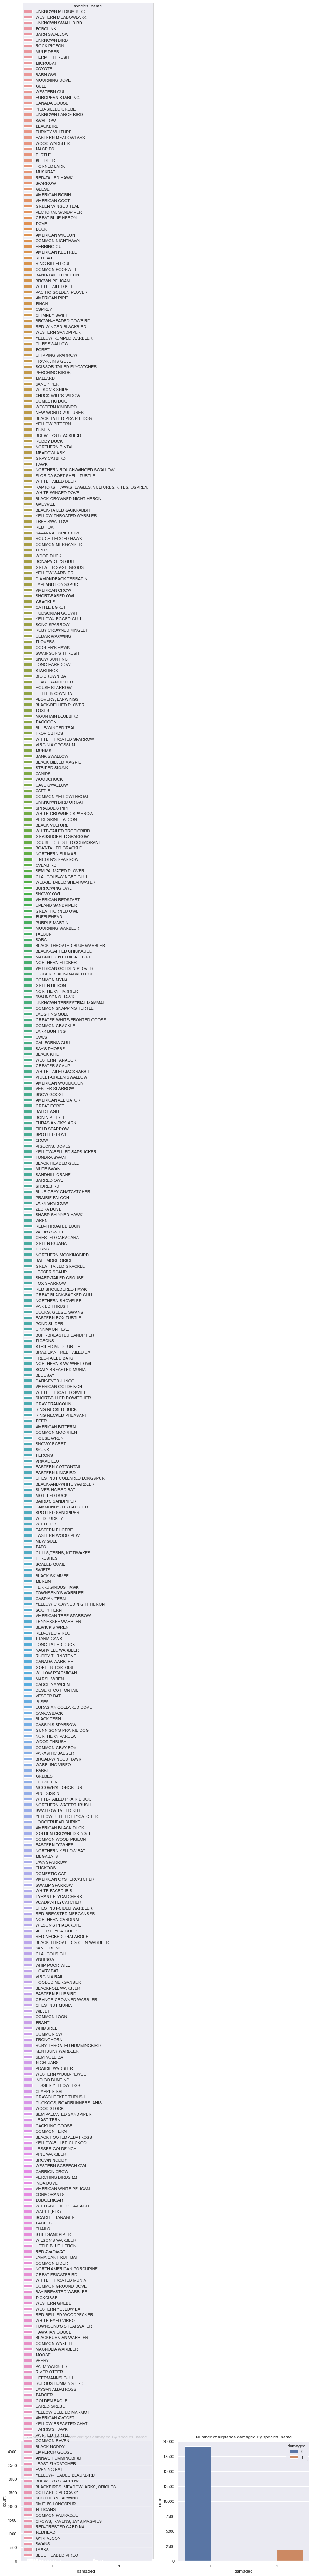

-----
  species_quantity   damaged
3         Over 100  0.428571
1           11-100  0.202899
2             2-10  0.129909
0                1  0.077907
Count Of:species_quantity
species_quantity
1           17675
11-100        138
2-10         2648
Over 100        7
dtype: int64


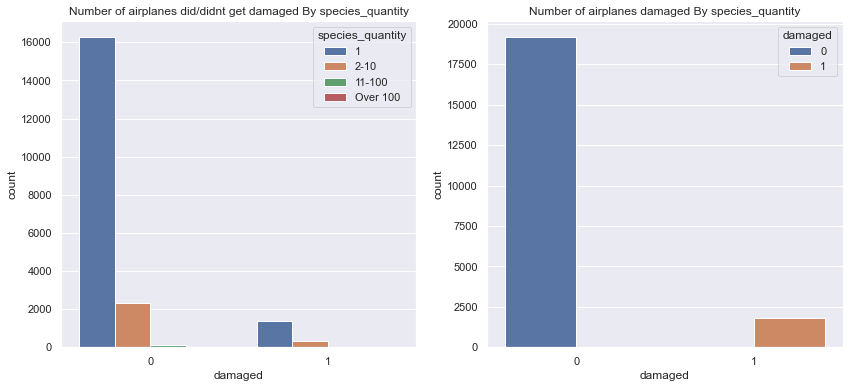

-----
           flight_impact   damaged
2        ENGINE SHUTDOWN  0.969697
1       ENGINE SHUT DOWN  0.806452
4                  OTHER  0.501718
5  PRECAUTIONARY LANDING  0.446112
0        ABORTED TAKEOFF  0.234727
3                   NONE  0.074224
Count Of:flight_impact
flight_impact
ABORTED TAKEOFF            311
ENGINE SHUT DOWN            31
ENGINE SHUTDOWN             33
NONE                     10657
OTHER                      291
PRECAUTIONARY LANDING      733
dtype: int64


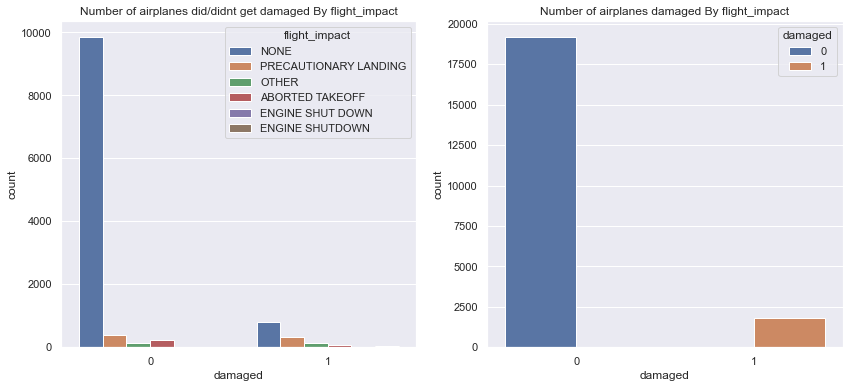

-----


In [146]:
visualize_objects(df,feature_types['object'])

           flight_impact   damaged
2        ENGINE SHUTDOWN  0.969697
1       ENGINE SHUT DOWN  0.806452
4                  OTHER  0.501718
5  PRECAUTIONARY LANDING  0.446112
0        ABORTED TAKEOFF  0.234727
3                   NONE  0.074224
Count Of flight_impact : green
flight_impact
ABORTED TAKEOFF            311
ENGINE SHUT DOWN            31
ENGINE SHUTDOWN             33
NONE                     10657
OTHER                      291
PRECAUTIONARY LANDING      733
dtype: int64


Text(0.5, 1.0, 'Number of passenger did/didnt Survived By Gender')

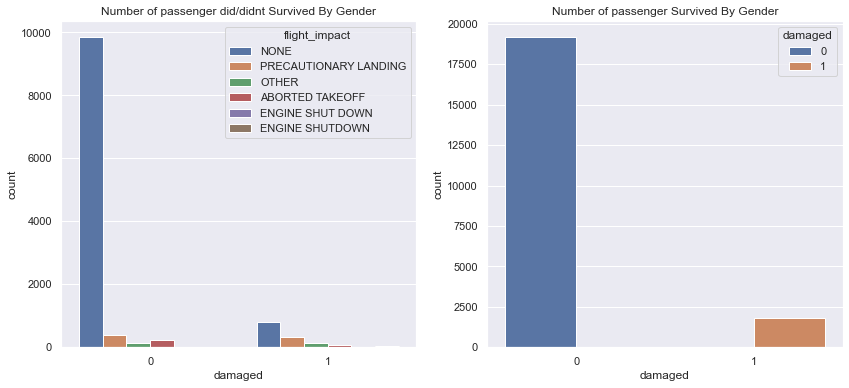

In [139]:
print(df[['flight_impact', 'damaged']].groupby(['flight_impact'], as_index=False).mean().sort_values(by='damaged', ascending=False))

print('Count Of flight_impact :','green')
# Showing  Count of Both gender Male/Female
print(df.groupby('flight_impact').size())

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(14,6))

# using .countplot() from seaborn to visualize  Count of each gender and survived percent
sns.countplot(x = 'damaged', hue='flight_impact', data=df, ax =  axis1)
axis2.set_title('Number of passenger Survived By Gender')

sns.countplot(x='damaged',data=df,hue='damaged', ax = axis2)
axis1.set_title('Number of passenger did/didnt Survived By Gender')

## Cleaning

1. Drop redundent data (id + name)
2. Clean text
   - lower case
   - remove spaces 
   - remove "-"
3. Columns that should be converted to objects
4. Columns that should be converted to int
5. Columns that should be converted to float

## Missing Values
Lots of missing data! Need to decide what to do with it.

1. Can we bring in other datasets? if so we can get an airport_id dataset to fill in nulls for state and possible other variables.

## Feature Engineer

1. Can we bring i